In [1]:
import json
import string
import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
with open('/content/Mental Health Conversational.json', 'r') as content:
  chatbot = json.load(content)
data = pd.DataFrame(chatbot['intents'])

In [4]:
dictionary = {"tag":[], "patterns":[], "responses":[]}
for i in range (len(data)):
  pattern = data[data.index==i]['patterns'].values[0]
  response = data[data.index==i]['responses'].values[0]
  tag = data[data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(pattern[j])
    dictionary['responses'].append(response)
data = pd.DataFrame.from_dict(dictionary)
data

,tag,patterns,responses
0,greeting,Hai,[Halo! Selamat bertemu denganmu. Bagaimana kab...
1,greeting,Halo,[Halo! Selamat bertemu denganmu. Bagaimana kab...
2,greeting,Hai apa kabar?,[Halo! Selamat bertemu denganmu. Bagaimana kab...
3,greeting,Hi,[Halo! Selamat bertemu denganmu. Bagaimana kab...
4,greeting,Assalamualaikum,[Halo! Selamat bertemu denganmu. Bagaimana kab...
...,...,...,...
212,fact_28,Bagaimana saya bisa menjaga hubungan sosial? B...,"[Banyak orang yang sendirian saat ini, tapi ki..."
213,fact_29,Apa perbedaan antara kecemasan dan stress?,[Stres dan kecemasan sering digunakan secara b...
214,fact_29,perbedaan kecemasan dan stress,[Stres dan kecemasan sering digunakan secara b...
215,fact_30,Apa perbedaan antara kesedihan dan depresi?,[Kesedihan merupakan reaksi normal terhadap ke...


In [5]:
with open('/content/Validation_Conversation.json', 'r') as content:
  val_chatbot = json.load(content)
val_data = pd.DataFrame(val_chatbot['intents'])


In [6]:
dictionary = {"tag":[], "patterns":[]}
for i in range (len(val_data)):
  pattern = val_data[val_data.index==i]['patterns'].values[0]
  tag = val_data[val_data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(pattern[j])
val_data = pd.DataFrame.from_dict(dictionary)
val_data

,tag,patterns
0,greeting,Halo
1,greeting,Hai apa kabar?
2,greeting,Hi
3,morning,pagi
4,afternoon,siang
...,...,...
111,fact_26,Apa yang harus saya lakukan jika saya khawatir...
112,fact_27,Bagaimana saya tahu kalau saya tidak sehat?
113,fact_28,Bagaimana saya bisa menjaga hubungan sosial? B...
114,fact_29,perbedaan kecemasan dan stress


In [7]:
# Training
data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30'], dtype=object)

In [8]:
# Validation
val_data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30'], dtype=object)

In [9]:
with open('/content/word_dict.json', 'r') as f:
  json_dict = json.load(f)
tokenizer_json=json_dict.keys()

tokenizer = Tokenizer(lower=True, split=' ', oov_token='<OOV>')
tokenizer.fit_on_texts(tokenizer_json)

word_index = tokenizer.word_index
print(len(word_index))

18727


In [10]:
data = shuffle(data)
val_data = shuffle(val_data)

In [11]:
label_encode = LabelEncoder()

tokenizer.fit_on_texts(data['patterns'])
tokenizer.fit_on_texts(val_data['patterns'])

# Training Set
pattern_train = tokenizer.texts_to_sequences(data['patterns'])
x_train = pad_sequences(pattern_train, padding='post', maxlen=12, truncating='pre')
print("Training Input Shape : ", x_train.shape)
print(len(x_train[0]))

x_label = label_encode.fit_transform(data['tag'])
print("Training Label Shape : ", x_label.shape)
print("Num of classes: ", len(np.unique(x_label)))

Training Input Shape :  (217, 12)
12
Training Label Shape :  (217,)
Num of classes:  75


In [12]:
# Validation Set
pattern_val = tokenizer.texts_to_sequences(val_data['patterns'])
y_train = pad_sequences(pattern_val, padding='post', maxlen=12, truncating='pre')
print("Validation Input Shape : ", y_train.shape)
print(len(y_train[0]))

y_label = label_encode.fit_transform(val_data['tag'])
print("Validation Label Shape : ",y_label.shape)
print("Num of classes: ", len(np.unique(y_label)))

Validation Input Shape :  (116, 12)
12
Validation Label Shape :  (116,)
Num of classes:  75


In [13]:
vocabulary = len(tokenizer.word_index)
print("Number unique word : ",vocabulary)
print("Output Length : ", label_encode.classes_.shape[0])


Number unique word :  18756
Output Length :  75


In [14]:
# !rm -f glove.6B.zip
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-16 02:59:20--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-16 02:59:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-12-16 03:01:59 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [15]:
glove_dir = "/content/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding='utf8')
for line in file_:
  arr = line.split()
  single_word = arr[0]
  w = np.asarray(arr[1:],dtype='float32')
  embeddings_index[single_word] = w
file_.close()
print(len(embeddings_index))

400000


In [16]:
max = vocabulary + 1
word_index =tokenizer.word_index
embedding_mat = np.zeros((max, 100)).astype(object)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_mat[i] = embedding_vector

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_length=x_train.shape[1], input_dim=vocabulary+1, output_dim = 100, mask_zero=True,
                              weights=[embedding_mat], trainable=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(np.unique(x_label)), activation='softmax')
])

model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 12, 100)           1875700   
                                                                 
 dropout_14 (Dropout)        (None, 12, 100)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 12, 256)           176640    
 onal)                                                           
                                                                 
 layer_normalization_15 (La  (None, 12, 256)           512       
 yerNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 12, 256)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)              

In [37]:
def chatbot_test():
  while True:
    user_input = input("User: ").lower()

    pattern_test = tokenizer.texts_to_sequences([user_input])
    x_test = pad_sequences(pattern_test, x_train.shape[1])

    prediction = model.predict(x_test)[0]
    label = label_encode.inverse_transform([np.argmax(prediction)])[0]
    response = data[data['tag'] == label]['responses'].values[0]
    print("Label:",label)
    print("Chatbot: ", format(random.choice(response)))
    if label=='goodbye' or label=='thanks':
      break

In [38]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.8:
            self.model.stop_training = True

In [39]:
history = model.fit(x_train, x_label, validation_data=(y_train, y_label),
                    batch_size=32, epochs=1000, callbacks=[MyCallback()])

Epoch 1/1000
7/7 [==============================] - 32s 1s/step - loss: 4.6248 - accuracy: 0.0184 - val_loss: 3.9600 - val_accuracy: 0.1638
Epoch 2/1000
7/7 [==============================] - 1s 113ms/step - loss: 4.0026 - accuracy: 0.1152 - val_loss: 3.5620 - val_accuracy: 0.2414
Epoch 3/1000
7/7 [==============================] - 1s 100ms/step - loss: 3.5733 - accuracy: 0.1475 - val_loss: 3.2139 - val_accuracy: 0.3103
Epoch 4/1000
7/7 [==============================] - 1s 107ms/step - loss: 3.2721 - accuracy: 0.2350 - val_loss: 2.8824 - val_accuracy: 0.3534
Epoch 5/1000
7/7 [==============================] - 1s 112ms/step - loss: 3.0031 - accuracy: 0.3180 - val_loss: 2.5634 - val_accuracy: 0.3707
Epoch 6/1000
7/7 [==============================] - 1s 111ms/step - loss: 2.6960 - accuracy: 0.3410 - val_loss: 2.3205 - val_accuracy: 0.3793
Epoch 7/1000
7/7 [==============================] - 1s 96ms/step - loss: 2.5213 - accuracy: 0.4009 - val_loss: 2.0830 - val_accuracy: 0.4138
Epoch 8/1

In [ ]:
def plot_training_history(history):
    # Plotting training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.ylim(0, 1.0)

    # Plotting training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='yellow')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.ylim(0, 1.0)

    # Display the plots
    plt.show()


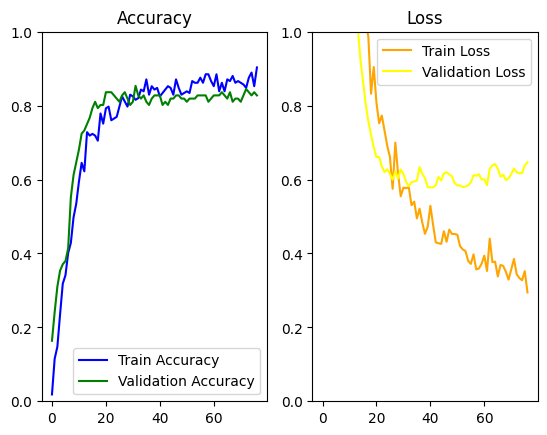

In [40]:
plot_training_history(history)

In [42]:
chatbot_test()

User: halo
1/1 [==============================] - 0s 25ms/step
Label: greeting
Chatbot:  Halo! Senang bertemu denganmu. Apa yang bisa saya bantu?
User: kamu siapa? 
1/1 [==============================] - 0s 25ms/step
Label: stupid
Chatbot:  Aku harap kamu tidak mengatakan hal-hal yang menyakitkan seperti itu. Maaf jika aku tidak berguna
User: aku harus memanggilmu apa?
1/1 [==============================] - 0s 53ms/step
Label: worthless
Chatbot:  Wajar jika merasa seperti ini. Ceritakan lebih banyak. Apa lagi yang ada di pikiranmu?
User: kamu bisa ngapain aja
1/1 [==============================] - 0s 25ms/step
Label: skill
Chatbot:  Saya dapat memberikan nasihat umum mengenai kecemasan dan depresi, menjawab pertanyaan terkait kesehatan mental, dan melakukan percakapan sehari-hari. Perlu diingat bahwa saya bukan sebagai pengganti ahli kesehatan mental.
User: yang membuatmu
1/1 [==============================] - 0s 27ms/step
Label: creation
Chatbot:  Saya diciptakan oleh Tim CH2-PS423 Ba

In [ ]:
tf.saved_model.save(model,'/content/TFLite/')


In [ ]:
saved_model_path = '/content/TFLite/'


loaded_model = tf.saved_model.load(saved_model_path)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('chatbot_model.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
from google.colab import files
files.download('chatbot_model.tflite')